In [1]:
# imports
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats

from surprise import AlgoBase
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import NMF
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import CoClustering
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold

In [2]:
# constants and initialization
dataset = 'book'#options:'lfm', anime', 'book', 'ml'
folds = 5
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
top_fraction = 0.2
user_events_file = 'data/' + dataset + '/user_events.txt'
low_user_file = 'data/' + dataset + '/low_main_users.txt'
medium_user_file = 'data/' + dataset + '/medium_main_users.txt'
high_user_file = 'data/' + dataset + '/high_main_users.txt'

In [3]:
# read user events and users
cols = ['user', 'item', 'preference']
df_events = pd.read_csv(user_events_file, sep=',', names=cols, skiprows=1)
print('No. of user events: ' + str(len(df_events)))
# read users
low_users = pd.read_csv(low_user_file, sep=',').set_index('user')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user')
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))
print('No. of events per user: ' + str(len(df_events) / no_users))

No. of user events: 577414
No. of users: 3000
No. of events per user: 192.47133333333332


In [4]:
# get item distribution
item_dist = df_events['item'].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = ['count']
df_item_dist['count'] /= no_users
print('No. of events per item: ' + str(len(df_events) / num_items))

No. items: 223607
No. of events per item: 2.582271574682367


In [5]:
# sparsity
1 - len(df_events) / (no_users * num_items)

0.9991392428084392

In [6]:
# rating range
print('Min rating: ' + str(df_events['preference'].min()))
print('Max rating: ' + str(df_events['preference'].max()))

Min rating: 1
Max rating: 10


In [7]:
# get fractions
user_hist = [] # user history sizes
pop_item_fraq = [] # average popularity of items in user profiles
for u, df in df_events.groupby('user'):
    no_user_items = len(set(df['item'])) # profile size
    user_hist.append(no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df['item']] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)

R-value: -0.10349887733393134
R2-value: 0.010712017609384167
P-value: 1.333089962842547e-08
Slope: -2.147257127744078e-06
Intercept: 0.008033295497360884
SpearmanrResult(correlation=-0.029463149865013246, pvalue=0.10664875433349329)


(array([-0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,
         0.035,  0.04 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

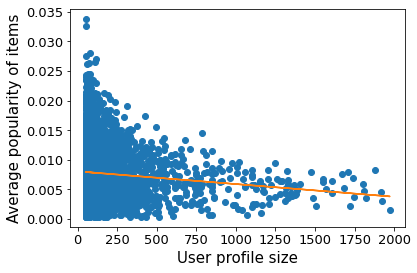

In [8]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_item_fraq)
print('R-value: ' + str(r_value))
print('R2-value: ' + str(r_value**2))
print('P-value: ' + str(p_value))
print('Slope: ' + str(slope))
print('Intercept: ' + str(intercept))
print(stats.spearmanr(user_hist, pop_item_fraq))

line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_item_fraq, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='15')
plt.ylabel('Average popularity of items', fontsize='15')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
#plt.savefig('data/' + dataset + '/plots/corr_user_avg.png', dpi=300, bbox_inches='tight')

In [9]:
# start recommender

In [10]:
reader = Reader(rating_scale=(df_events['preference'].min(), df_events['preference'].max()))

In [11]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_events, reader)

In [12]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [13]:
def get_mae_of_groups(predictions):
    #print('All: ')
    #all_mae = accuracy.mae(predictions)
    all_predictions = []
    low_predictions = []
    med_predictions = []
    high_predictions = []
    for uid, iid, true_r, est, details in predictions:
        prediction = [(uid, iid, true_r, est, details)]
        if uid in low_users.index:
            low_predictions.append(accuracy.mae(prediction, verbose=False))
        elif uid in medium_users.index:
            med_predictions.append(accuracy.mae(prediction, verbose=False))
        else:
            high_predictions.append(accuracy.mae(prediction, verbose=False))          
    low_mae = np.mean(low_predictions)
    #print('LowMS: ' + str(low_mae))
    med_mae = np.mean(med_predictions)
    #print('MedMS: ' + str(med_mae))
    high_mae = np.mean(high_predictions)
    #print('HighMS: ' + str(high_mae))
    all_mae = np.mean([low_mae, med_mae, high_mae])
    #print('All: ' + str(all_mae))
    print('Low vs. med: ' + str(stats.ttest_ind(low_predictions, med_predictions)))
    print('Low vs. high: ' + str(stats.ttest_ind(low_predictions, high_predictions)))
    
    return low_mae, med_mae, high_mae, all_mae

In [14]:
sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
algos = []

algos.append(KNNBasic(sim_options = sim_users, k=40)) 
algos.append(KNNWithMeans(sim_options = sim_users, k=40))
algos.append(NMF(n_factors = 30, random_state=my_seed))
algos.append(CoClustering(n_cltr_u=3, n_cltr_i=3, random_state=my_seed))
algo_names = ['KNNBasic',
              'KNNWithMeans',
              'NMF',
              'CoClustering']

kf = KFold(n_splits=folds, random_state = my_seed)
for i in range(0, len(algo_names)):
    df_item_dist[algo_names[i]] = 0
    low_maes = []
    med_maes = []
    high_maes = []
    all_maes = []
    print(algo_names[i])
    fold_count = 0
    for trainset, testset in kf.split(data):
        # calculate and evaluate recommendations
        algos[i].fit(trainset)
        predictions = algos[i].test(testset)        
        low_mae, med_mae, high_mae, all_mae = get_mae_of_groups(predictions)
        low_maes.append(low_mae)
        med_maes.append(med_mae)
        high_maes.append(high_mae)
        all_maes.append(all_mae)
        # get top-n recommendation counts
        top_n = get_top_n(predictions, n=10)
        for uid, user_ratings in top_n.items():
            for (iid, _) in user_ratings:
                df_item_dist.loc[iid, algo_names[i]] += 1
        
    print('LowMS: ' + str(np.mean(low_maes)))
    print('MedMS: ' + str(np.mean(med_maes)))
    print('HighMS: ' + str(np.mean(high_maes)))
    print('All: ' + str(np.mean(all_maes)))
    print('\n')

KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Low vs. med: Ttest_indResult(statistic=29.704408177552097, pvalue=7.121790816902162e-193)
Low vs. high: Ttest_indResult(statistic=21.731251363841945, pvalue=2.3117205670978658e-104)
Computing the cosine similarity matrix...
Done computing similarity matrix.
Low vs. med: Ttest_indResult(statistic=30.141333918590743, pvalue=1.6828254453395456e-198)
Low vs. high: Ttest_indResult(statistic=21.46833473174342, pvalue=6.616412082133779e-102)
Computing the cosine similarity matrix...
Done computing similarity matrix.
Low vs. med: Ttest_indResult(statistic=29.15430666242501, pvalue=6.5329765401151425e-186)
Low vs. high: Ttest_indResult(statistic=21.874269453731422, pvalue=1.0394039548684252e-105)
Computing the cosine similarity matrix...
Done computing similarity matrix.
Low vs. med: Ttest_indResult(statistic=28.320788090319702, pvalue=1.3496657261027797e-175)
Low vs. high: Ttest_indResult(statistic=20.13419850

<ipython-input-14-2a22a05ce454>:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algos[i].fit(trainset)


Low vs. med: Ttest_indResult(statistic=32.854163009481894, pvalue=3.363512229719217e-235)
Low vs. high: Ttest_indResult(statistic=27.60399003579305, pvalue=7.915030922847516e-167)
Low vs. med: Ttest_indResult(statistic=32.87211407947041, pvalue=1.8565299364010856e-235)
Low vs. high: Ttest_indResult(statistic=26.0187270349218, pvalue=1.5753417135823736e-148)
Low vs. med: Ttest_indResult(statistic=31.00493249905858, pvalue=7.51788913604561e-210)
Low vs. high: Ttest_indResult(statistic=25.62319965187707, pvalue=3.9391839360106404e-144)
Low vs. med: Ttest_indResult(statistic=31.552177741699623, pvalue=3.3640368195124922e-217)
Low vs. high: Ttest_indResult(statistic=24.64356395302538, pvalue=1.6228114003670552e-133)
Low vs. med: Ttest_indResult(statistic=31.027101130658338, pvalue=3.8363897886649505e-210)
Low vs. high: Ttest_indResult(statistic=26.31298291999862, pvalue=7.607031116467079e-152)
LowMS: 1.3920402606722113
MedMS: 1.134910999149797
HighMS: 1.1629121973921115
All: 1.2299544857380

KNNBasic
SpearmanrResult(correlation=0.41548946105699786, pvalue=0.0)
KNNWithMeans
SpearmanrResult(correlation=0.4413895748942565, pvalue=0.0)
NMF
SpearmanrResult(correlation=0.4142016633192495, pvalue=0.0)
CoClustering
SpearmanrResult(correlation=0.41271325869964653, pvalue=0.0)


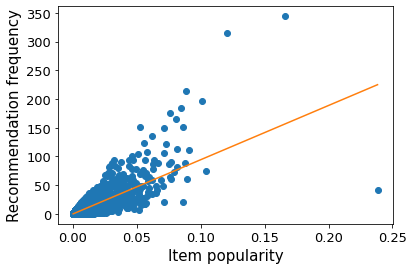

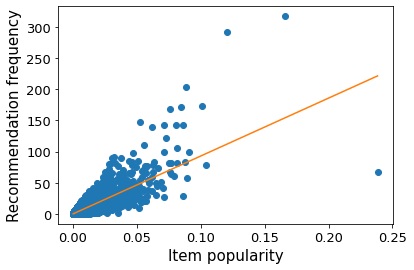

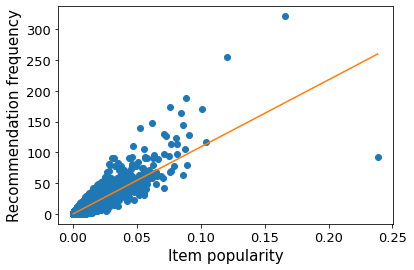

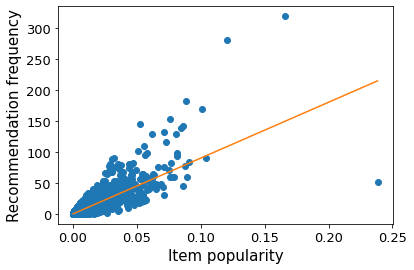

In [15]:
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist['count']
    y = df_item_dist[algo_names[i]]
    #plt.gca().set_ylim(0, 300)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * np.array(x) + intercept
    print(algo_names[i])
    print(stats.spearmanr(x, y))
    plt.plot(x, y, 'o', x, line)
    plt.xlabel('Item popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    #plt.savefig('data/' + dataset + '/plots/rec_' + algo_names[i] + '.png', dpi=300, bbox_inches='tight')